# FORT Atom Dynamics Simulator (FADS) #
P. Huft

TODO: need to set numpy error to raise in amophys so the overflow error can be caught and handled

In [8]:
# dynamic = True # whether to auto-update plots during monte carlo sims.
# if dynamic:
#     %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import warnings # for catching warnings
import numpy as np
np.seterr(all='warn')
from numpy import *
from random import random as rand
from scipy.integrate import solve_ivp
from time import time

## local imports
import sys, os
sys.path.append('..\\')
sys.path.append('..\\utilities')
from physconsts import *
from rbconsts import mRb
from amophys import dipole_trap, projected_dark_trap
from simfuncs import soln_to_csv, soln_from_csv

# where to save the results
solndir = '.\\solns'

## make the display wide
# from IPython.core.display import display,HTML
# display(HTML("<style>.container{width:100% !important;}</style>"))

In [9]:
## misc functions

def squarewave(d,tau,t,n):
    """ square wave with duty cycle 'd' and period 'tau' [s]
        evaluated at time 't' % tau. 
        'n': number of Fourier terms
    """
    t = t % tau
    
    term = lambda m: 2*(1-cos(m*pi*d))*sin(m*pi*t/tau)/(m*pi)
    sqwv = 0
    for i in range(1,n):
        sqwv += term(i)
    
    return sqwv

## experiment functions - for evolving atomic motion in a FORT

def example(someparam,x,y,z,vx,vy,vz,m=mRb):
    """
    prototypical experiment
    
    x,y,z,vx,vy,vz are the atom position and velocity components
    """
    #TODO: put your experiment here
    
    return x,y,z,vx,vy,vz

def fort_drop(t_drop,x,y,z,vx,vy,vz,m=mRb):
    """
    simply evolve the atom position in free space.
    
    x,y,z,vx,vy,vz are the atom position and velocity components
    t_drop [s]
    """
    x += vx*t_drop
    y += vy*t_drop
    z += vz*t_drop - 0.5*g*t_drop**2
    return x,y,z,vx,vy,vz

def fort_chop(dt,a,uforce,x,y,z,vx,vy,vz,m=mRb,aargs=[],fullsoln=False,ivpkwargs={}):
    """
    dt float duration in seconds
    a = lambda t,step... giving temporal modulation amplitude at step
    uforce list of three lambdas for force, taking  x,y,z. units [N]
    x,y,z,vx,vy,vz are the atom position and velocity components
    aargs is an optional list of args to be passed to a
    """
    
    fx,fy,fz = uforce

    def derivs(t,y):
        x,y,z,vx,vy,vz = y
        
        xdot = vx
        ydot = vy
        zdot = vz
        vxdot = fx(x,y,z)*a(t,*aargs)/m
        vydot = fy(x,y,z)*a(t,*aargs)/m
        vzdot = fz(x,y,z)*a(t,*aargs)/m
        
        return xdot,ydot,zdot,vxdot,vydot,vzdot
                
    y0 = [x,y,z,vx,vy,vz]
    tdomain = [0, dt]
    soln = solve_ivp(derivs,tdomain,y0,**ivpkwargs)
    xl,yl,zl,vxl,vyl,vzl = soln.y
    
    x = xl[-1]
    y = yl[-1]
    z = zl[-1]
    vx = vxl[-1]
    vy = vyl[-1]
    vz = vzl[-1]

    if fullsoln:
        return xl,yl,zl,vxl,vyl,vzl
        
    return x,y,z,vx,vy,vz

def fort_const(dt,uforce,x,y,z,vx,vy,vz,m=mRb,fullsoln=False,ivpkwargs={}):
    """
    fort on with constant amplitude for duration dt
    
    dt float duration in seconds
    cycles int number of chop periods
    a = lambda t,step... giving temporal modulation amplitude at step
    uforce list of lambdas for force in x,y,z, units [N]
    x,y,z,vx,vy,vz are the atom position and velocity components
    """
    
    fx,fy,fz = uforce

    def derivs(t,y):
        x,y,z,vx,vy,vz = y
        
        xdot = vx
        ydot = vy
        zdot = vz
        vxdot = fx(x,y,z)/m
        vydot = fy(x,y,z)/m
        vzdot = fz(x,y,z)/m
        
        return xdot,ydot,zdot,vxdot,vydot,vzdot
                
    y0 = [x,y,z,vx,vy,vz]
    tdomain = [0, dt]
    soln = solve_ivp(derivs,tdomain,y0,**ivpkwargs)
    xl,yl,zl,vxl,vyl,vzl = soln.y
    
    x = xl[-1]
    y = yl[-1]
    z = zl[-1]
    vx = vxl[-1]
    vy = vyl[-1]
    vz = vzl[-1]

    if fullsoln:
        return xl,yl,zl,vxl,vyl,vzl
        
    return x,y,z,vx,vy,vz

## dark traps

zr=3.89 [um], wx=1.00 [um]


<IPython.core.display.Javascript object>


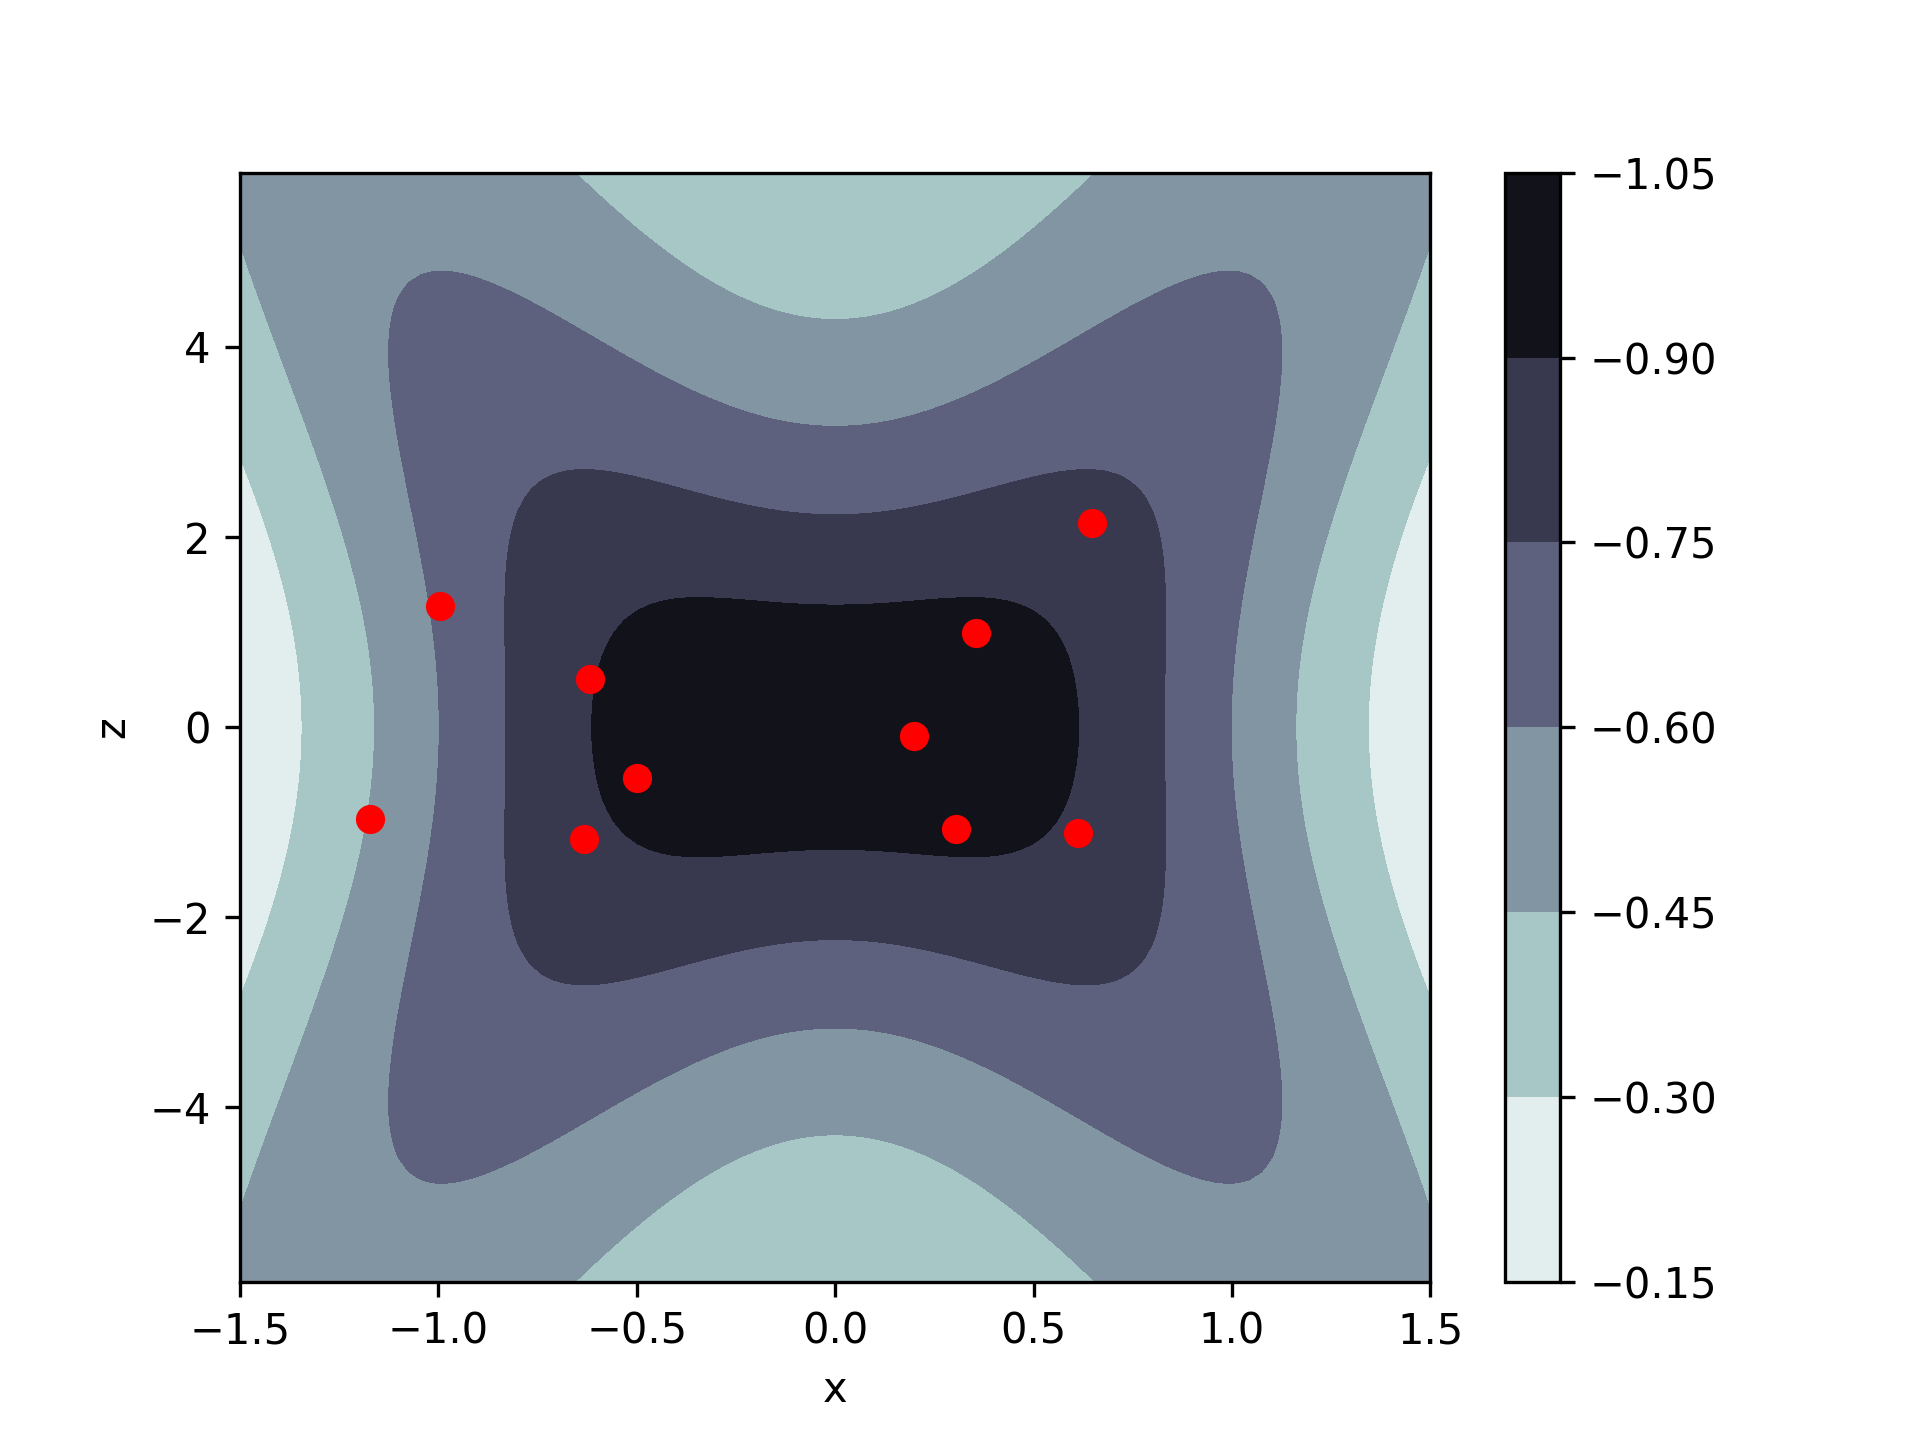

In [6]:
# dipole trap and atom setup
w0 = 1 # 1/e^2 waist of trap [um]
T_trap = 5e-4 # energy depth [K]
T_atom = 7e-5
lmbda_trap = 0.808 # [um]
m = 2.20694650e-25 # Cs

# my dipole trap object for getting atom dists
trap = projected_dark_trap(lmbda_trap,w0,T_trap,T_atom,m=m,units=1e-6)
trap.distplot(10)

<IPython.core.display.Javascript object>


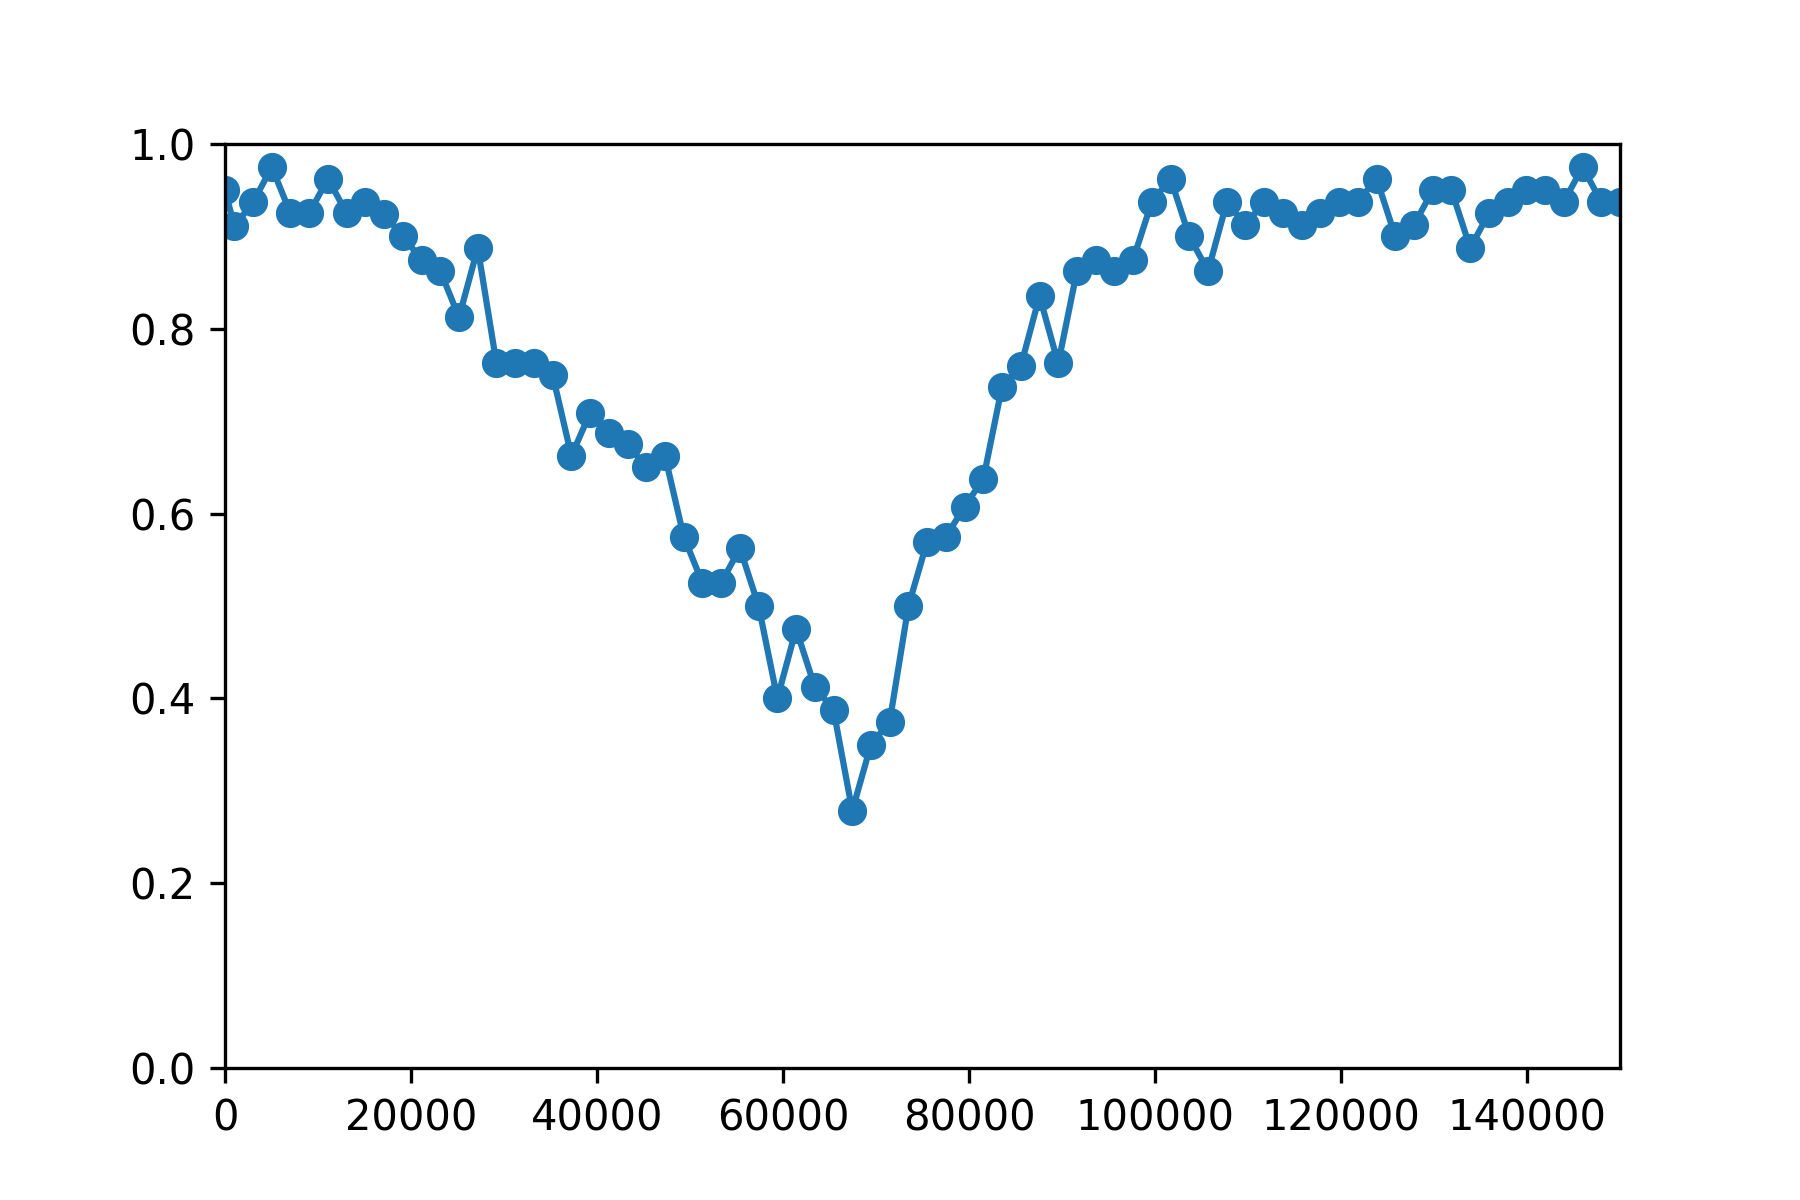

C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 0 done in 358.78 s. loaded 80, retained 76
iteration 1 done in 223.22 s. loaded 79, retained 72


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 2 done in 223.34 s. loaded 79, retained 74
iteration 3 done in 185.93 s. loaded 80, retained 78
iteration 4 done in 208.89 s. loaded 80, retained 74
iteration 5 done in 177.55 s. loaded 80, retained 74
iteration 6 done in 197.69 s. loaded 80, retained 77
iteration 7 done in 279.53 s. loaded 80, retained 74


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:774: RuntimeWarning: underflow encountered in double_scalars
  +(w0/w)**2*Irho) - 1)


iteration 8 done in 208.72 s. loaded 80, retained 75


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 9 done in 222.81 s. loaded 79, retained 73


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 10 done in 213.27 s. loaded 80, retained 72


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 11 done in 208.57 s. loaded 80, retained 70


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 12 done in 205.73 s. loaded 80, retained 69


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 13 done in 208.31 s. loaded 80, retained 65


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 14 done in 205.38 s. loaded 80, retained 71


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 15 done in 195.64 s. loaded 80, retained 61


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 16 done in 197.09 s. loaded 80, retained 61


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 17 done in 213.19 s. loaded 80, retained 61


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 18 done in 191.51 s. loaded 80, retained 60


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 19 done in 180.29 s. loaded 80, retained 53


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 20 done in 201.73 s. loaded 79, retained 56


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 21 done in 182.97 s. loaded 80, retained 55


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 22 done in 187.50 s. loaded 80, retained 54


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 23 done in 183.16 s. loaded 80, retained 52


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 24 done in 193.03 s. loaded 80, retained 53


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 25 done in 170.03 s. loaded 80, retained 46


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 26 done in 170.16 s. loaded 80, retained 42


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:774: RuntimeWarning: underflow encountered in double_scalars
  +(w0/w)**2*Irho) - 1)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:774: RuntimeWarning: underflow encountered in double_scalars
  +(w0/w)**2*Irho) - 1)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encounte

iteration 27 done in 152.90 s. loaded 80, retained 42


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 28 done in 158.56 s. loaded 80, retained 45


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 29 done in 152.44 s. loaded 80, retained 40


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 30 done in 130.16 s. loaded 80, retained 32


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 31 done in 133.41 s. loaded 80, retained 38


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 32 done in 110.54 s. loaded 80, retained 33


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 33 done in 95.41 s. loaded 80, retained 31


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 34 done in 87.77 s. loaded 79, retained 22


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 35 done in 100.50 s. loaded 80, retained 28


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = 

iteration 36 done in 130.95 s. loaded 80, retained 30


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 37 done in 152.66 s. loaded 80, retained 40


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:774: RuntimeWarning: underflow encountered in double_scalars
  +(w0/w)**2*Irho) - 1)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 38 done in 148.07 s. loaded 79, retained 45


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 39 done in 159.42 s. loaded 80, retained 46


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 40 done in 161.04 s. loaded 79, retained 48


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 41 done in 172.88 s. loaded 80, retained 51


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 42 done in 182.29 s. loaded 80, retained 59


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 43 done in 188.80 s. loaded 79, retained 60


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 44 done in 185.22 s. loaded 79, retained 66
iteration 45 done in 187.33 s. loaded 80, retained 61


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 46 done in 194.01 s. loaded 80, retained 69


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 47 done in 202.40 s. loaded 80, retained 70


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 48 done in 202.07 s. loaded 80, retained 69


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 49 done in 191.69 s. loaded 80, retained 70
iteration 50 done in 207.73 s. loaded 80, retained 75
iteration 51 done in 209.03 s. loaded 80, retained 77


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 52 done in 200.99 s. loaded 80, retained 72
iteration 53 done in 203.67 s. loaded 80, retained 69


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 54 done in 201.25 s. loaded 79, retained 74


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 55 done in 195.25 s. loaded 80, retained 73


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 56 done in 206.52 s. loaded 80, retained 75
iteration 57 done in 190.10 s. loaded 80, retained 74


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 58 done in 210.16 s. loaded 80, retained 73
iteration 59 done in 209.60 s. loaded 80, retained 74
iteration 60 done in 200.11 s. loaded 79, retained 74
iteration 61 done in 199.72 s. loaded 80, retained 75


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 62 done in 208.59 s. loaded 80, retained 77


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 63 done in 209.60 s. loaded 80, retained 72


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 64 done in 215.17 s. loaded 80, retained 73


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 65 done in 214.36 s. loaded 80, retained 76


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 66 done in 215.98 s. loaded 80, retained 76


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 67 done in 212.61 s. loaded 80, retained 71


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 68 done in 218.93 s. loaded 80, retained 74


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 69 done in 216.99 s. loaded 80, retained 75


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 70 done in 212.72 s. loaded 80, retained 76


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 71 done in 223.17 s. loaded 80, retained 76
iteration 72 done in 208.03 s. loaded 80, retained 75
iteration 73 done in 215.21 s. loaded 80, retained 78


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 74 done in 218.29 s. loaded 80, retained 75


C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)
C:\Users\prest\Documents\Python\rubidium\amophys.py:759: RuntimeWarning: underflow encountered in exp
  Irho = exp(-2*rr/w**2)


iteration 75 done in 215.27 s. loaded 80, retained 75
wrote data to .\solns\trap_chop_1e+00mK_4e+01uK_w0_1e+00um_lmbda_8e-01um_steps_start-1e+00_stop2e+05_76pts_80meas_642691.csv


In [12]:
## projected dark trap |1-e_g|^2 - trap frequency scan

# what to print during the simulation
fullsoln = True # for debugging with fort_const experiment, return the motion and velocity at every time step in the default experiment
no_warnings = True # suppress warnings that are printed by the ODE solver
verbose_m = False # print measurement status
verbose_i = True # print iteration status

# optional keyword arguments for IVP ODE solver
ivpkwargs = {'method':'RK45'}

# freq scan, Hz
# -1 is the default exp with a constant fort amplitude for t_gap
prefix = "trap_chop" # goes at the beginning of experiment csv file name
scan_steps = [-1]+list(linspace(1e3,150e3,75)) # [73734] 

iters = len(scan_steps)
measurements = 80

# dipole trap and atom setup
w0 = 1e-6 # 1/e^2 waist of trap [um]
T_trap = 1e-3 # energy depth [K]
T_atom = 4e-5
lmbda_trap = 0.808e-6 # [um]
m = 2.20694650e-25 # Cs
units = 1 # 1 if m, 1e-3 if mm, etc

# my dipole trap object for getting atom dists, potential function, and forces
trap = projected_dark_trap(lmbda_trap,w0,T_trap,T_atom,m=m,units=units)

# forces in x,y,z
uforce = trap.Uforce()
u = trap.U

# experiment definition
dt = .020 # total chopping duration; neglect the 20 ms time in the constant trap
t_gap = 0.04 # gap between shots
a = lambda t,freq: 1 - 0.2*sin(pi*t*freq)**2
experiment = lambda x,y,z,vx,vy,vz,freq: (
                fort_chop(dt,a,uforce,x,y,z,vx,vy,vz,m,[freq],fullsoln,ivpkwargs=ivpkwargs) # freq gets passed to a
             )
# what to do if step = -1; step should be the last argument, but is unused.
default = lambda x,y,z,vx,vy,vz,step: fort_const(t_gap,uforce,x,y,z,vx,vy,vz,m,fullsoln,ivpkwargs=ivpkwargs)

# atom position and velocity sampling functions
# takes number of samples n and returns lists x_samples,y_samples,z_samples
xsamp = trap.xdist
vsamp = trap.vdist

retention = zeros(iters)
loading = zeros(iters,int)
failed = []

# use to store the position solns if fullsoln
xsolns = []
ysolns = []
zsolns = []

# plot setup
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(111)
if dynamic:
    plt.ion()
    fig.show()
    fig.canvas.draw()

for ii,step in enumerate(scan_steps):

    ti0 = time()
    
    # generate an ensemble of positions and speeds
    x_dist,y_dist,z_dist = xsamp(measurements)
    vx_dist,vy_dist,vz_dist = vsamp(measurements)

    retained = 0
    loaded = 0
    
    # no loading filter
    for jj,x,y,z,vx,vy,vz in zip(range(measurements),
                                 x_dist,y_dist,z_dist,
                                 vx_dist,vy_dist,vz_dist):
        
        tm0 = time()
        
         # condition the experiment on atoms that are initially trapped
        KE = .5*m*(vx**2+vy**2+vz**2)
        PE = u(x,y,z) # the dipole trap potential energy
        
#         print("shot0")
#         print(x,y,z)
#         print(vx,vy,vz)
#         print(KE/PE)
        
        if KE + PE < 0: # "shot 0"
            
            loaded +=1

            with warnings.catch_warnings(record=True):
#                 if no_warnings:
#                     warnings.simplefilter(record=True)
                
                # evolve atom during the science phase
                if step == -1:
                    func = default
                else:
                    func = experiment
                
                if fullsoln:
                    xl,yl,zl,vxl,vyl,vzl = func(x,y,z,vx,vy,vz,step)

                    xsolns.append(xl)
                    ysolns.append(yl)
                    zsolns.append(zl)

                    x = xl[-1]
                    y = yl[-1]
                    z = zl[-1]
                    vx = vxl[-1]
                    vy = vyl[-1]
                    vz = vzl[-1]

                else:
                    x,y,z,vx,vy,vz = func(x,y,z,vx,vy,vz,step)

            # check if an atom is still trapped
            KE = .5*m*(vx**2+vy**2+vz**2)
            try:
                PE = u(x,y,z)
            except RuntimeWarning:
                print(f"oops! x,y,z={x,y,z}")
                failed.append[[x,y,z]]
            
#             print("shot1")
#             print(x,y,z)
#             print(vx,vy,vz)
            if KE + PE < 0: # "shot 1"
                retained += 1
            
        if verbose_m:
            print(f"measurement {jj} done in {time()-tm0:.2f} s")
                
    if loaded > 0:
        retention[ii] = retained/loaded
        loading[ii] = loaded
    
    if verbose_i:
        print(f"iteration {ii} done in {time()-ti0:.2f} s. loaded {loaded}, retained {retained}") 
    
    if dynamic:
        ax.clear()
        ax.plot(scan_steps[:ii+1],retention[:ii+1])
        ax.scatter(scan_steps[:ii+1],retention[:ii+1])
        ax.set_ylim((0,1))
        ax.set_xlim((scan_steps[0],scan_steps[-1]))
        fig.canvas.draw()
if not dynamic:
    ax.plot(scan_steps,retention)
    ax.scatter(scan_steps,retention)
    ax.set_ylim((0,1))
    ax.set_xlim((scan_steps[0],scan_steps[-1]))
    
# save the data on completion.
int(1e6*rand())

s0 = scan_steps[0]
sf = scan_steps[-1]
sn = len(scan_steps)

fname = f'{prefix}_{trap.Tdepth*1e3:.0e}mK_{trap.T*1e6:.0e}uK_w0_{trap.wx*1e6:.0e}um_lmbda_{trap.lmbda*1e6:.0e}um_steps_start{s0:.0e}_stop{sf:.0e}_{sn}pts_{measurements}meas_{int(1e6*rand())}.csv'
soln_to_csv(os.path.join(solndir,fname),[retention,loading],labels=['retention','loading'])

17977

In [16]:
loading

array([80, 80, 80, 80, 80, 80, 80, 80, 80,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [14]:
s0 = scan_steps[0]
sf = scan_steps[-1]
sn = len(scan_steps)

fname = f'trap_chop_{trap.Tdepth*1e3:.0e}mK_{trap.T*1e6:.0e}uK_w0_{trap.wx*1e6:.0e}um_lmbda_{trap.lmbda*1e6:.0e}um_steps_start{s0:.0e}_stop{sf:.0e}_{sn}pts_{measurements}meas.csv'
if write:
    soln_to_csv(os.path.join(solndir,fname),[retention,loading],labels=['retention','loading'])
    write = False

wrote data to .\solns\trap_chop_1e+00mK_2e+01uK_w0_1e+00um_lmbda_8e-01um_steps_start-1e+00_stop1e+05_51pts_80meas.csv


In [9]:
fname = 'trap_chop_1e+00mK_2e+01uK_w0_1e+00um_lmbda_8e-01um_steps_start-1e+00_stop1e+05_51pts_80meas.csv'
data,labels = soln_from_csv(os.path.join(solndir,fname))

In [13]:
len(data[1])

51

<IPython.core.display.Javascript object>


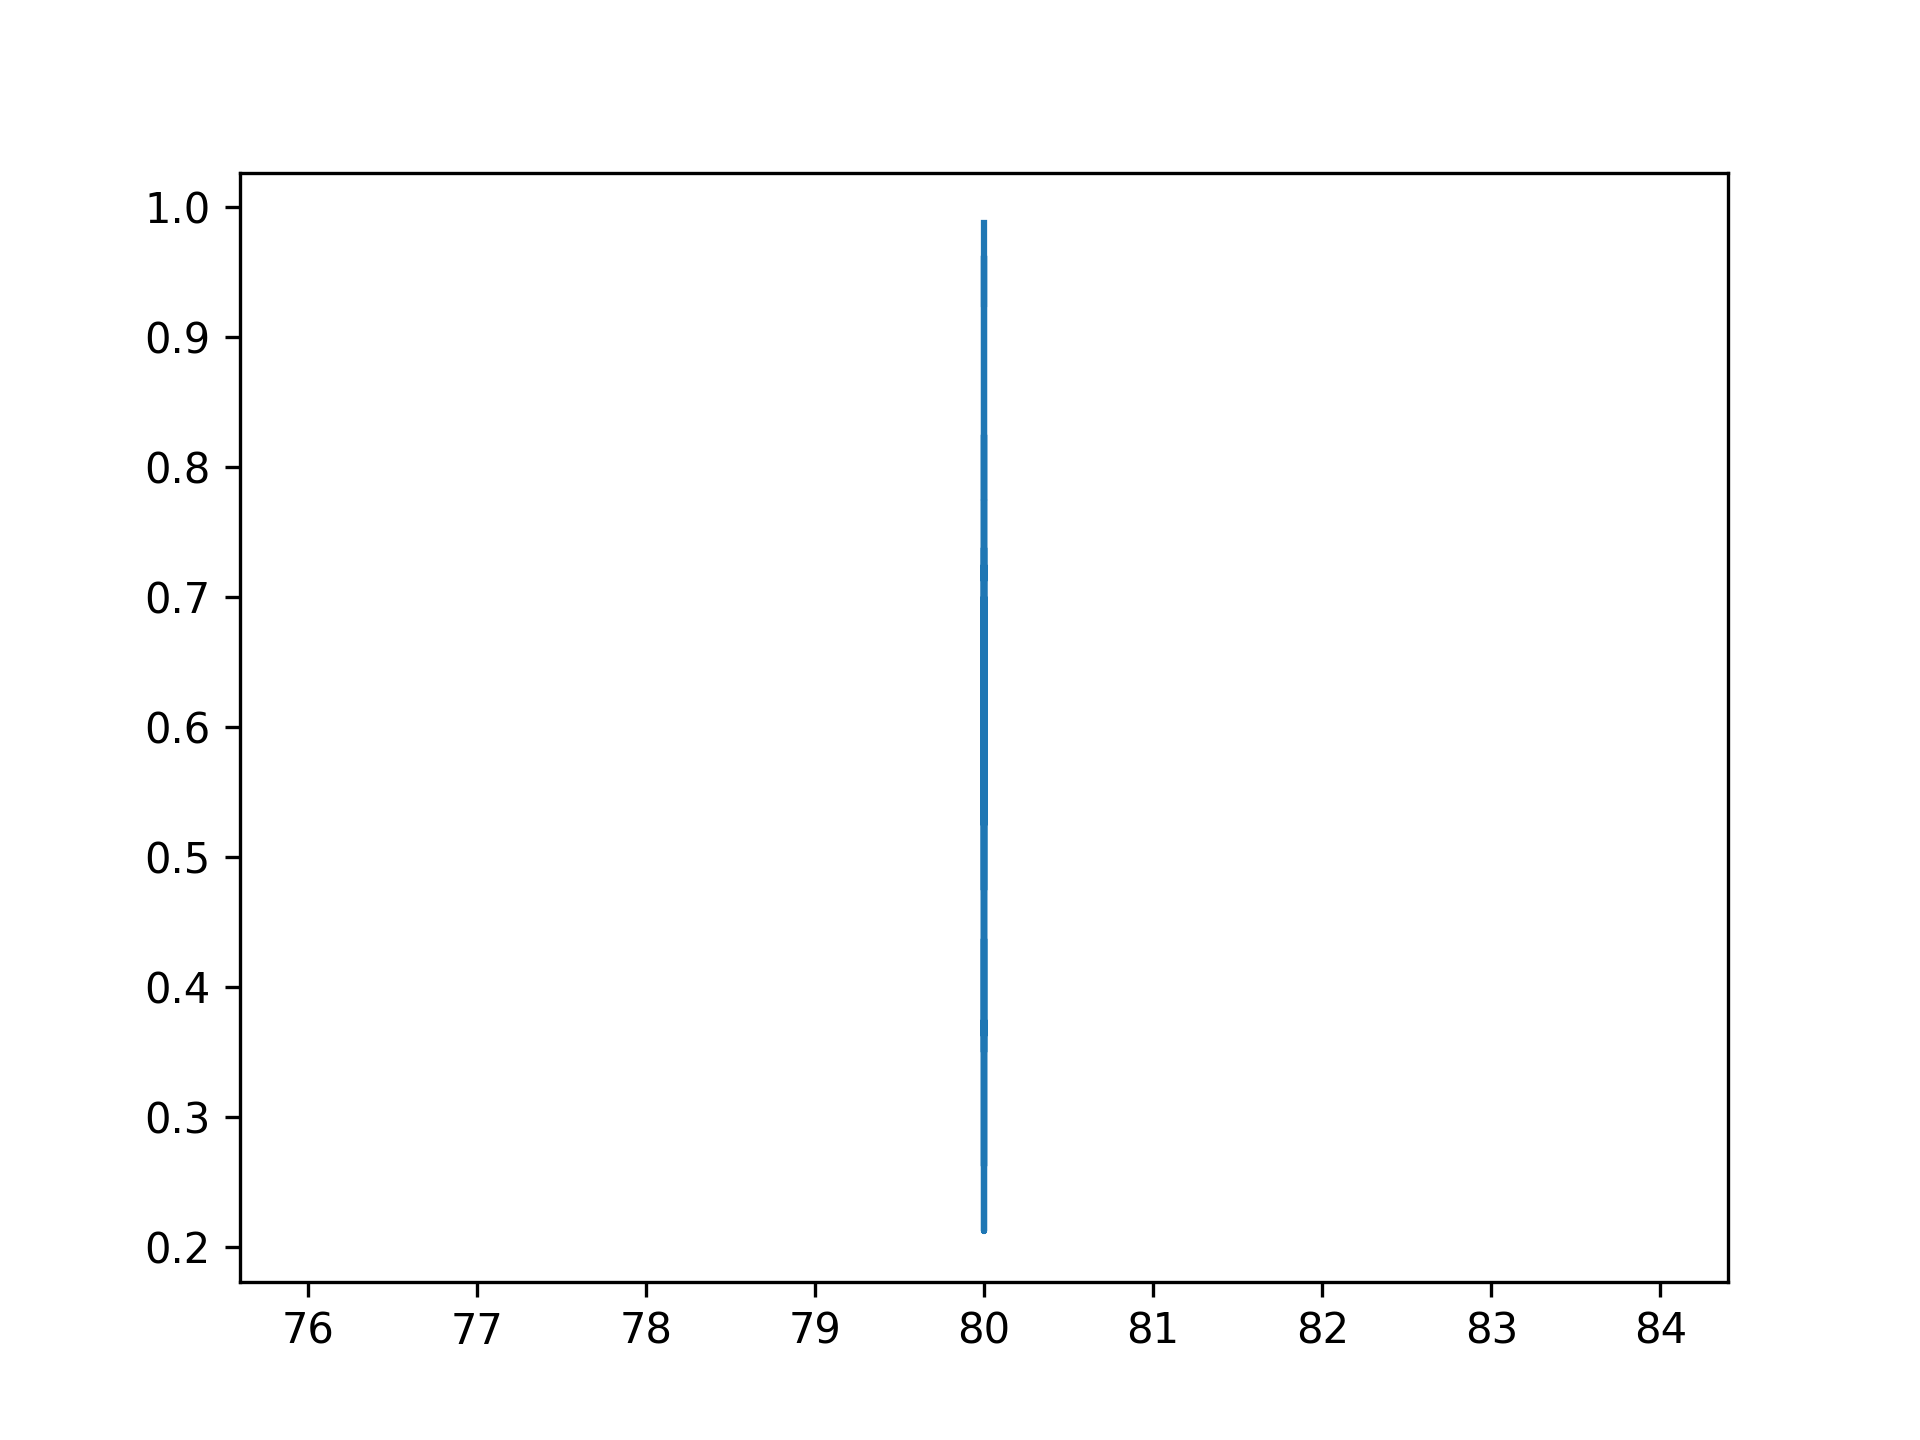

C:\Users\prest\.virtualenvs\rubidium-6bgZCrz4\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [14]:
plt.plot(data[1],data[0])

In [13]:
write=True

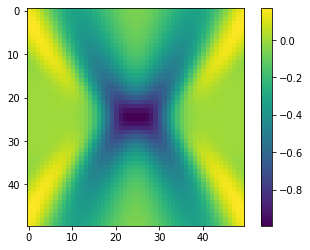

In [12]:
x = linspace(-4*w0,4*w0)
z = linspace(-4*trap.zR,4*trap.zR)
xx,zz = meshgrid(x,z)
fig,ax = plt.subplots()
cbar = ax.imshow(u(xx,0,zz)/(kB*trap.Tdepth))
fig.colorbar(cbar)

## bright traps

In [ ]:
## bright trap - trap frequency scan

verbose_m = False # print measurement status
verbose_i = True # print iteration status

# freq scan, Hz
# -1 is the default exp with a constant fort amplitude for t_gap
scan_steps = list(linspace(130e3,190e3,30))

# dipole trap and atom setup
w0 = 2.4e-6 # 1/e^2 waist of trap [m]
T_trap = 5.5e-3 # energy depth [K]
T_atom = 5e-5
lmbda_trap = 1.038e-6 # [m]
m = mRb

# my dipole trap object for getting atom dists
trap = dipole_trap(lmbda_trap,w0,T_trap,T_atom,m=m)

# forces in x,y,z
uforce = trap.Uforce()
u = trap.U

# experiment definition
dt = .020 # total chopping duration; neglect the 20 ms time in the constant trap
t_gap = 0.04 # gap between shots
a = lambda t,freq: 1 - 0.4*sin(pi*t*freq)**2
experiment = lambda x,y,z,vx,vy,vz,freq: (
                fort_chop(dt,a,uforce,x,y,z,vx,vy,vz,m,[freq]) # freq gets passed to a
             )
# what to do if step = -1:
default = lambda x,y,z,vx,vy,vz: fort_const(t_gap,uforce,x,y,z,vx,vy,vz,m)

# atom position and velocity sampling functions
xsamp = trap.xdist
vsamp = trap.vdist

iters = len(scan_steps)
measurements = 30

retention = zeros(iters)
loading = zeros(iters)

# plot setup
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(111)
# if dynamic:
#     plt.ion()
#     fig.show()
#     fig.canvas.draw()

for ii,step in enumerate(scan_steps):

    ti0 = time()
    
    # generate an ensemble of positions and speeds
    x_dist,y_dist,z_dist = xsamp(measurements)
    vx_dist,vy_dist,vz_dist = vsamp(measurements)

    retained = 0
    loaded = 0
    
    # no loading filter
    for jj,x,y,z,vx,vy,vz in zip(range(measurements),
                                 x_dist,y_dist,z_dist,
                                 vx_dist,vy_dist,vz_dist):
        
        tm0 = time()
        
         # condition the experiment on atoms that are initially trapped
        KE = .5*m*(vx**2+vy**2+vz**2)
        PE = u(x,y,z) # the dipole trap potential energy
        if KE + PE < 0: # "shot 0"
            
            loaded +=1

            # evolve atom during the science phase
            if step == -1:
                x,y,z,vx,vy,vz = default(x,y,z,vx,vy,vz)
            else:
                x,y,z,vx,vy,vz = experiment(x,y,z,vx,vy,vz,step)

            # check if an atom is still trapped
            KE = .5*m*(vx**2+vy**2+vz**2)
            PE = u(x,y,z)
            if KE + PE < 0: # "shot 1"
                retained += 1
            
            if verbose_m:
                print(f"measurement {jj} done in {time()-tm0:.2f} s")
                
    if loaded > 0:
        retention[ii] = retained/loaded
        loading[ii] = loaded
    
    if verbose_i:
        print(f"iteration {ii} done in {time()-ti0:.2f} s")        
    
    if dynamic:
        ax.clear()
        ax.plot(scan_steps[:ii+1],retention[:ii+1])
        ax.scatter(scan_steps[:ii+1],retention[:ii+1])
        ax.set_ylim((0,1))
        ax.set_xlim((scan_steps[0],scan_steps[-1]))
        fig.canvas.draw()
if not dynamic:
    ax.plot(scan_steps,retention)
    ax.scatter(scan_steps,retention)
    ax.set_ylim((0,1))
    ax.set_xlim((scan_steps[0],scan_steps[-1]))

## bright trap release recapture

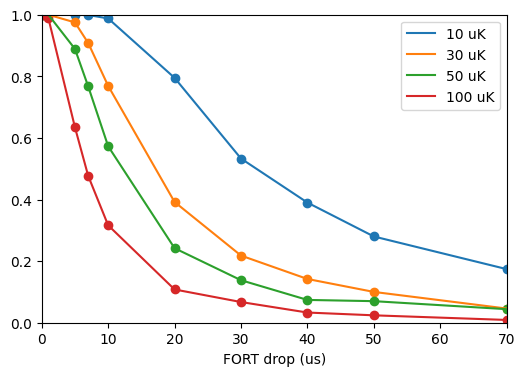

In [18]:
# experiment definition
experiment = lambda x,y,z,vx,vy,vz,step: (
                fort_drop(step,x,y,z,vx,vy,vz,m)
             )

# gap time scan, s
scan_steps = [0,1e-6,5e-6,7e-6,10e-6,20e-6,30e-6,40e-6,50e-6,70e-6]

# dipole trap and atom setup
w0 = 0.75 # 1/e^2 waist of trap [um]
T_trap = 1e-3 # energy depth [K]
lmbda_trap = .85 # [um]
units = 1e-6 # 1 if m, 1e-3 if mm, etc
m = mRb

T_atom_list = [1e-5, 3e-5, 5e-5, 1e-4]

# plot setup
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for T_atom in T_atom_list:

    # my dipole trap object for getting atom dists
    trap = dipole_trap(lmbda_trap,w0,T_trap,T_atom,m=m,units=units)
    
    # forces in x,y,z
    uforce = trap.Uforce()
    u = trap.U
    
    # atom position and velocity sampling functions
    xsamp = trap.xdist
    vsamp = trap.vdist
    
    iters = len(scan_steps)
    measurements = 1000
    
    retention = empty(iters)
    loading = empty(iters)
    
    # if dynamic:
    #     plt.ion()
    
    #     fig.show()
    #     fig.canvas.draw()
    
    for ii,step in enumerate(scan_steps):
    
        # generate an ensemble of positions and speeds
        x_dist,y_dist,z_dist = xsamp(measurements)
        vx_dist,vy_dist,vz_dist = vsamp(measurements)
    
        retained = 0
        loaded = 0
        
        # no loading filter
        for jj,x,y,z,vx,vy,vz in zip(range(measurements),
                                     x_dist,y_dist,z_dist,
                                     vx_dist,vy_dist,vz_dist):
            
             # condition the experiment on atoms that are initially trapped
            KE = .5*m*(vx**2+vy**2+vz**2)*units**2 # units**2 is to convert to [J]
            PE = u(x,y,z) # the dipole trap potential energy, [J]
            if KE + PE < 0: # "shot 0"
    
                loaded +=1
    
                # evolve atom during the science phase
                x,y,z,vx,vy,vz = experiment(x,y,z,vx,vy,vz,step)
    
                # check if an atom is still trapped
                KE = .5*m*(vx**2+vy**2+vz**2)*units**2
                PE = u(x,y,z)
                if KE + PE < 0: # "shot 1"
                    retained += 1
                    
        retention[ii] = retained/loaded
        loading[ii] = loaded
        
        # if dynamic:
        #     ax.clear()
        #     ax.plot(scan_steps[:ii+1],retention[:ii+1])
        #     ax.scatter(scan_steps[:ii+1],retention[:ii+1])
        #     ax.set_ylim((0,1))
        #     ax.set_xlim((scan_steps[0],scan_steps[-1]))
        #     fig.canvas.draw()
    # if not dynamic:
    ax.plot(np.array(scan_steps)*1e6,retention, label=f"{1e6*T_atom:.0f} uK")
    ax.scatter(np.array(scan_steps)*1e6,retention)
    ax.set_ylim((0,1))
    ax.set_xlabel("FORT drop (us)")
    ax.set_xlim((np.array(scan_steps[0])*1e6,np.array(scan_steps[-1])*1e6))
    ax.legend()

In [5]:
## experiment pseudo code

# scan steps = 

# trap potential(x,y,z) = 

# forces in x,y,z

# iters, measurements

# retention = empty(iter)
# loading = empty(iter)

# for ii, step in each zip(iter ii, scansteps)

    # ensemble of atoms

    # retained = 0
    # loaded = 0
    
    # for each measurement jj, no loading filter

        # for each atom kk
        
            # PE(atom rho,z)
            # KE(atom v)
            # if not too hot to capture:
            
                # loaded +=1
                
                # !!!the actual experiment phase...
                # atom rho,z,v = experiment(atom rho,z,v)
                
                # check if an atom remains. if so,
                    # retained += 1
        # retention[ii] = retained/loaded
        # loading[ii] = loaded
        
# plt retention (with error bars!)

## bright trap atom distributions

<IPython.core.display.Javascript object>


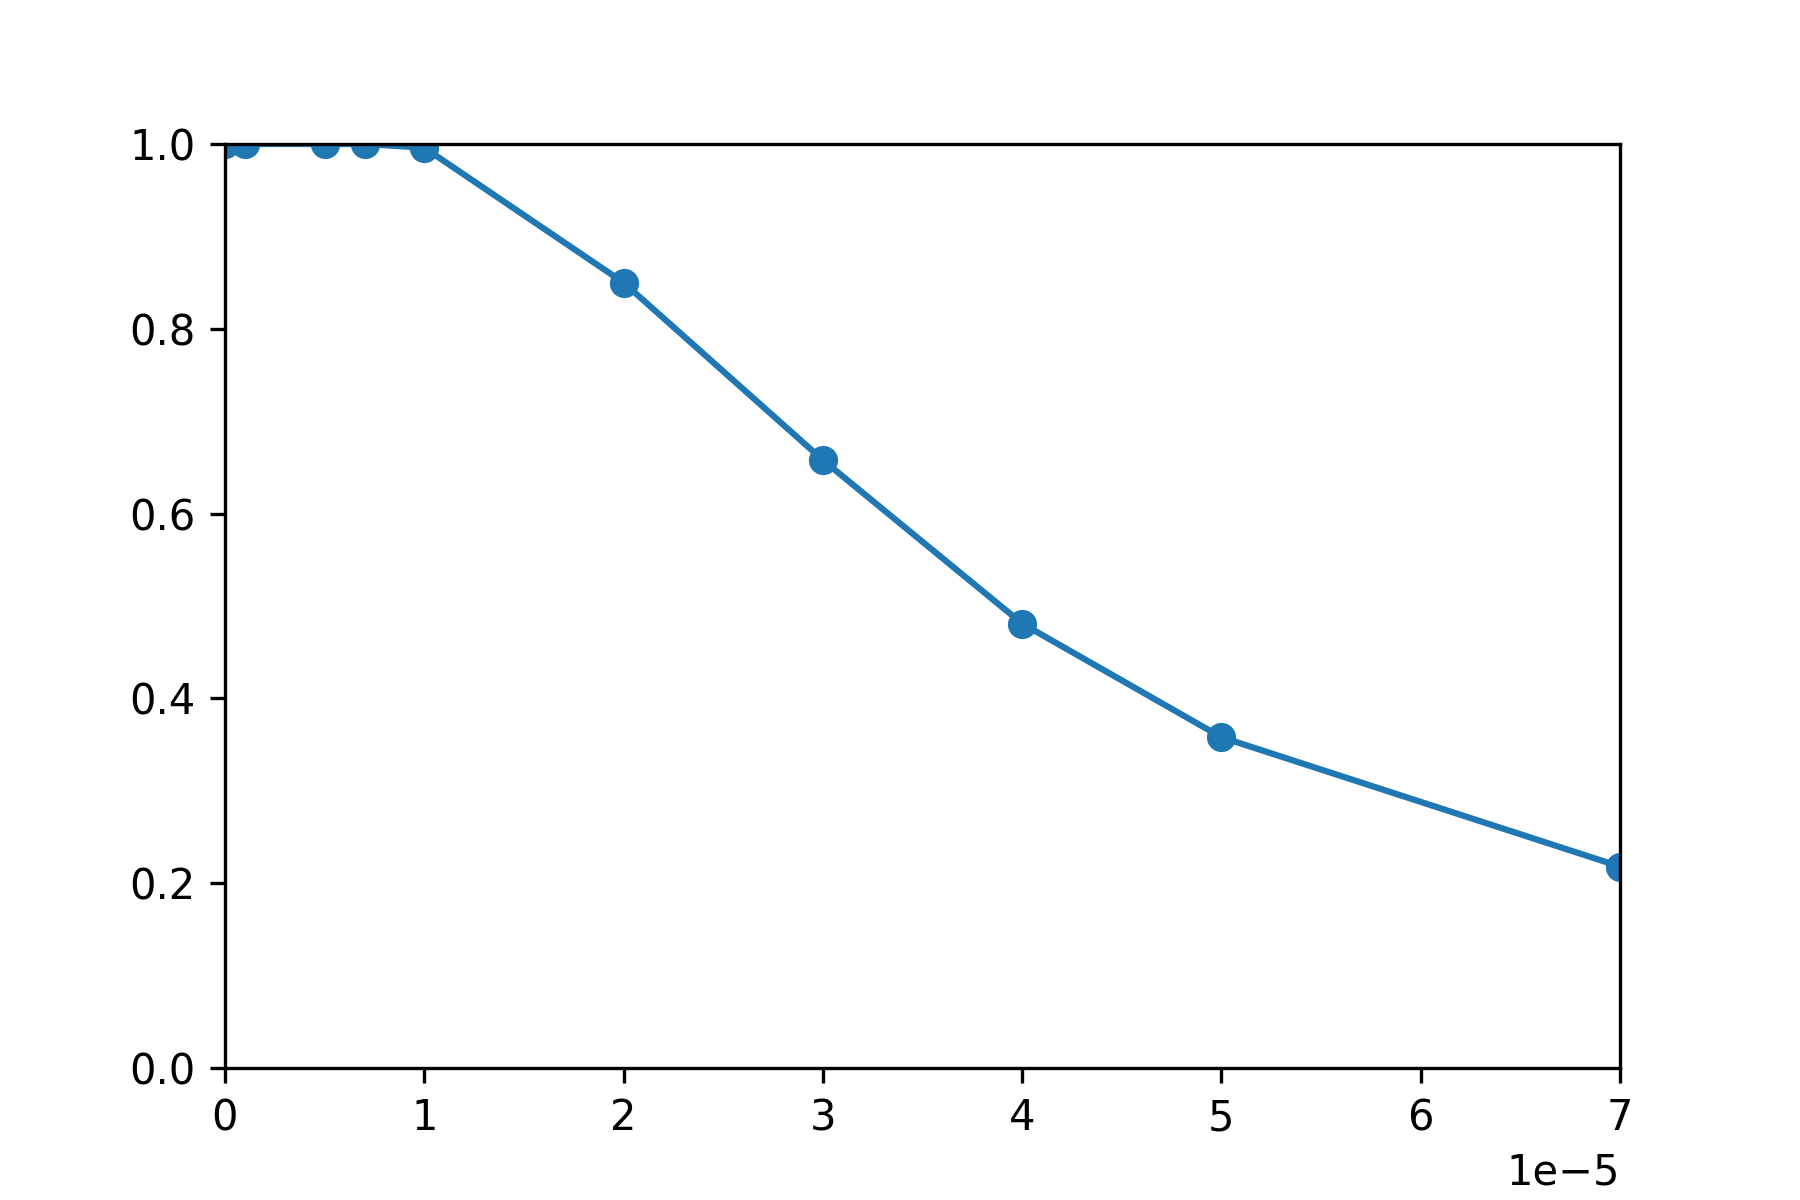

In [26]:
# experiment definition
experiment = lambda x,y,z,vx,vy,vz,step: (
                fort_drop(step,x,y,z,vx,vy,vz,m)
             )

# gap time scan, s
scan_steps = [0,1e-6,5e-6,7e-6,10e-6,20e-6,30e-6,40e-6,50e-6,70e-6]

# dipole trap and atom setup
w0 = 1 # 1/e^2 waist of trap [um]
T_trap = 5e-4 # energy depth [K]
T_atom = 1e-5
lmbda_trap = .81 # [um]
units = 1e-6 # 1 if m, 1e-3 if mm, etc
m = mRb

# my dipole trap object for getting atom dists
trap = dipole_trap(lmbda_trap,w0,T_trap,T_atom,m=m,units=units)

# forces in x,y,z
uforce = trap.Uforce()
u = trap.U

# atom position and velocity sampling functions
xsamp = trap.xdist
vsamp = trap.vdist

iters = len(scan_steps)
measurements = 1000

retention = empty(iters)
loading = empty(iters)

# plot setup
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
if dynamic:
    plt.ion()

    fig.show()
    fig.canvas.draw()

for ii,step in enumerate(scan_steps):

    # generate an ensemble of positions and speeds
    x_dist,y_dist,z_dist = xsamp(measurements)
    vx_dist,vy_dist,vz_dist = vsamp(measurements)

    retained = 0
    loaded = 0
    
    # no loading filter
    for jj,x,y,z,vx,vy,vz in zip(range(measurements),
                                 x_dist,y_dist,z_dist,
                                 vx_dist,vy_dist,vz_dist):
        
         # condition the experiment on atoms that are initially trapped
        KE = .5*m*(vx**2+vy**2+vz**2)*units**2 # units**2 is to convert to [J]
        PE = u(x,y,z) # the dipole trap potential energy, [J]
        if KE + PE < 0: # "shot 0"

            loaded +=1

            # evolve atom during the science phase
            x,y,z,vx,vy,vz = experiment(x,y,z,vx,vy,vz,step)

            # check if an atom is still trapped
            KE = .5*m*(vx**2+vy**2+vz**2)*units**2
            PE = u(x,y,z)
            if KE + PE < 0: # "shot 1"
                retained += 1
                
    retention[ii] = retained/loaded
    loading[ii] = loaded
    
    if dynamic:
        ax.clear()
        ax.plot(scan_steps[:ii+1],retention[:ii+1])
        ax.scatter(scan_steps[:ii+1],retention[:ii+1])
        ax.set_ylim((0,1))
        ax.set_xlim((scan_steps[0],scan_steps[-1]))
        fig.canvas.draw()
if not dynamic:
    ax.plot(scan_steps,retention)
    ax.scatter(scan_steps,retention)
    ax.set_ylim((0,1))
    ax.set_xlim((scan_steps[0],scan_steps[-1]))

## tests

### dark trap diagnostics

shot0
1.1577173253256277e-07 -1.6366103457512925e-07 3.040763414856197e-07
0.03312898217597401 -0.029074831432437186 -0.0029039051699946165
-0.0157073449932102


C:\Users\prest\.virtualenvs\rubidium-6bgZCrz4\lib\site-packages\scipy\integrate\_ivp\rk.py:119: RuntimeWarning: underflow encountered in nextafter
  min_step = 10 * np.abs(np.nextafter(t, self.direction * np.inf) - t)


shot1
-1.207581579317174e-07 -1.151926270986914e-08 4.9550555218850224e-08
-0.0008854391827381584 -0.006560912347431965 0.007661498629811052
iteration 0 done in 7.30 s


C:\Users\prest\AppData\Local\Temp/ipykernel_20608/3735163512.py:135: UserWarning: Attempting to set identical left == right == -1 results in singular transformations; automatically expanding.
  ax.set_xlim((scan_steps[0],scan_steps[-1]))


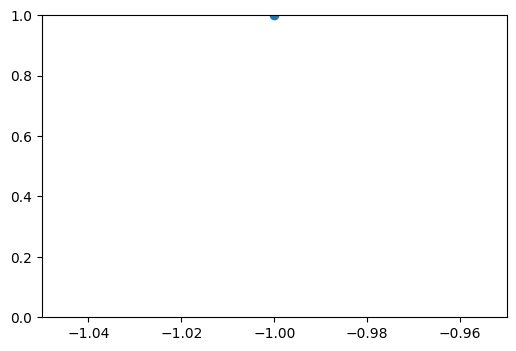

In [9]:
## Diagnosing the RuntimeWarning in solve_ivp
## projected dark trap |1-e_g|^2 - trap frequency scan

fullsoln = True # for debugging with fort_const experiment
verbose_m = False # print measurement status
verbose_i = True # print iteration status
    
# freq scan, Hz
# -1 is the default exp with a constant fort amplitude for t_gap
scan_steps =[-1] #+list(linspace(1e3,100e3,50)) # [73734] 

# dipole trap and atom setup
w0 = 1e-6 # 1/e^2 waist of trap [um]
T_trap = 1e-3 # energy depth [K]
T_atom = 2e-5
lmbda_trap = 0.808e-6 # [um]
m = 2.20694650e-25 # Cs
units = 1 # 1 if m, 1e-3 if mm, etc

# my dipole trap object for getting atom dists
trap = projected_dark_trap(lmbda_trap,w0,T_trap,T_atom,m=m,units=units)

# forces in x,y,z
uforce = trap.Uforce()
u = trap.U

# experiment definition
dt = .020 # total chopping duration; neglect the 20 ms time in the constant trap
t_gap = 0.04 # gap between shots
a = lambda t,freq: 1 - 0.4*sin(pi*t*freq)**2
experiment = lambda x,y,z,vx,vy,vz,freq: (
                fort_chop(dt,a,uforce,x,y,z,vx,vy,vz,m,[freq]) # freq gets passed to a
             )
# what to do if step = -1:
default = lambda x,y,z,vx,vy,vz: fort_const(t_gap,uforce,x,y,z,vx,vy,vz,m,fullsoln)

# atom position and velocity sampling functions
xsamp = trap.xdist
vsamp = trap.vdist

iters = len(scan_steps)
measurements = 1

retention = zeros(iters)
loading = zeros(iters)

# plot setup
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(111)
if dynamic:
    plt.ion()
    fig.show()
    fig.canvas.draw()

for ii,step in enumerate(scan_steps):

    ti0 = time()
    
    # generate an ensemble of positions and speeds
    x_dist,y_dist,z_dist = xsamp(measurements)
    vx_dist,vy_dist,vz_dist = vsamp(measurements)

    retained = 0
    loaded = 0
    
    # no loading filter
    for jj,x,y,z,vx,vy,vz in zip(range(measurements),
                                 x_dist,y_dist,z_dist,
                                 vx_dist,vy_dist,vz_dist):
        
        tm0 = time()
        
         # condition the experiment on atoms that are initially trapped
        KE = .5*m*(vx**2+vy**2+vz**2)
        PE = u(x,y,z) # the dipole trap potential energy
        
        print("shot0")
        print(x,y,z)
        print(vx,vy,vz)
        print(KE/PE)
        
        if KE + PE < 0: # "shot 0"
            
            loaded +=1

            # evolve atom during the science phase
            if step == -1:
                if fullsoln:
                    xl,yl,zl,vxl,vyl,vzl = default(x,y,z,vx,vy,vz)
    
                    x = xl[-1]
                    y = yl[-1]
                    z = zl[-1]
                    vx = vxl[-1]
                    vy = vyl[-1]
                    vz = vzl[-1]

                else:
                    x,y,z,vx,vy,vz = default(x,y,z,vx,vy,vz)
            else:
                x,y,z,vx,vy,vz = experiment(x,y,z,vx,vy,vz,step)

            # check if an atom is still trapped
            KE = .5*m*(vx**2+vy**2+vz**2)
            PE = u(x,y,z)
            
            print("shot1")
            print(x,y,z)
            print(vx,vy,vz)
            
            if KE + PE < 0: # "shot 1"
                retained += 1
            
        if verbose_m:
            print(f"measurement {jj} done in {time()-tm0:.2f} s")
                
    if loaded > 0:
        retention[ii] = retained/loaded
        loading[ii] = loaded
    
    if verbose_i:
        print(f"iteration {ii} done in {time()-ti0:.2f} s")        
    
    if dynamic:
        ax.clear()
        ax.plot(scan_steps[:ii+1],retention[:ii+1])
        ax.scatter(scan_steps[:ii+1],retention[:ii+1])
        ax.set_ylim((0,1))
        ax.set_xlim((scan_steps[0],scan_steps[-1]))
        fig.canvas.draw()
if not dynamic:
    ax.plot(scan_steps,retention)
    ax.scatter(scan_steps,retention)
    ax.set_ylim((0,1))
    ax.set_xlim((scan_steps[0],scan_steps[-1]))

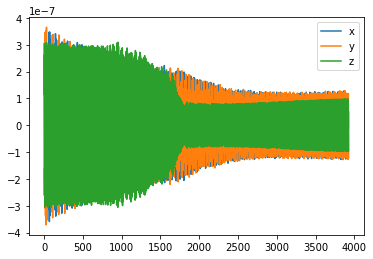

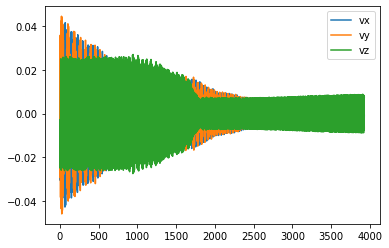

In [10]:
tl = range(len(xl))
plt.plot(tl,xl,label='x')
plt.plot(tl,yl,label='y')
plt.plot(tl,zl,label='z')
plt.legend()
plt.show()
plt.plot(tl,vxl,label='vx')
plt.plot(tl,vyl,label='vy')
plt.plot(tl,vzl,label='vz')
plt.legend()
plt.show()

In [14]:
x = xl[i]
y = yl[i]
z = zl[i]
vx = vxl[i]
vy = vyl[i]
vz = vzl[i]
KE = .5*m*(vx**2+vy**2+vz**2)
PE = u(x,y,z)
KE + PE

-1.3790564067817925e-26

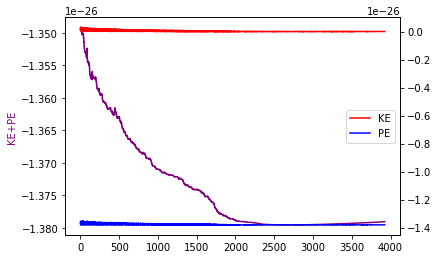

In [19]:
fig,ax = plt.subplots()
ax.plot(tl, .5*m*(vxl**2+vyl**2+vzl**2) + u(xl,yl,zl),label="KE + PE",c='purple')
ax.set_ylabel('KE+PE',c='purple')
ax2 = ax.twinx()
ax2.plot(tl, .5*m*(vxl**2+vyl**2+vzl**2),label="KE",c='red')
ax2.plot(tl, u(xl,yl,zl),label="PE",c='blue')
ax2.legend()

In [26]:
PE/(kB*trap.Tdepth)

-0.9541990100376881

In [27]:
trap.zR

3.888109719789348e-06

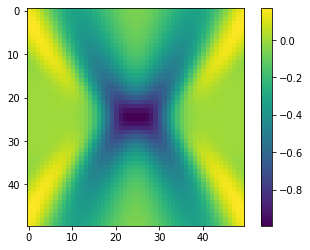

In [12]:
x = linspace(-4*w0,4*w0)
z = linspace(-4*trap.zR,4*trap.zR)
xx,zz = meshgrid(x,z)
fig,ax = plt.subplots()
cbar = ax.imshow(u(xx,0,zz)/(kB*trap.Tdepth))
fig.colorbar(cbar)

In [7]:
# dark trap and atom setup
w0 = 1 # 1/e electric field Gaussian waist [m]
T_trap = 5e-4 # energy depth [K]
T_atom = 2e-5
lmbda_trap = .808 # [m]
m = mRb

# my dipole trap object for getting atom dists
trap = projected_dark_trap(lmbda_trap,w0,T_trap,T_atom,m,units=1e-6)
trap.distplot(1000)

zr=3888109.72 [um], wx=1000000.00 [um]


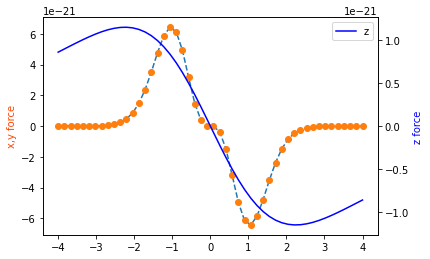

In [4]:
fx,fy,fz = trap.Uforce()

xpts = ypts = zpts = linspace(-4*w0,4*w0,50)
# zpts = linspace(-100*trap.zR,100*trap.zR,50)

fig,ax = plt.subplots()
ax.plot(xpts,fx(xpts,0,0),'--',label='x')
ax.plot(ypts,fy(0,ypts,0),'o',label='y')
ax.set_ylabel("x,y force",c='orangered')
ax2 = ax.twinx()
ax2.plot(zpts,fz(0,0,zpts),label='z',c='blue')
ax2.set_ylabel("z force",c='blue')
plt.legend()

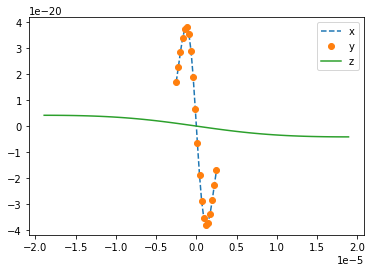

In [5]:
# dipole trap and atom setup
w0 = 2.5e-6 # 1/e^2 waist of trap [m]
T_trap = 5.7e-3 # energy depth [K]
T_atom = 1e-5
lmbda_trap = 1.038e-6 # [m]
m = mRb

# my dipole trap object for getting atom dists
trap = dipole_trap(lmbda_trap,w0,T_trap,T_atom,m=m)

# forces in x,y,z
uforce = trap.Uforce()
u = trap.U

fx,fy,fz = uforce

xpts = ypts = linspace(-w0,w0,20)
zpts = zpts = linspace(-trap.zR,trap.zR)
plt.plot(xpts,fx(xpts,0,0),'--',label='x')
plt.plot(ypts,fy(0,ypts,0),'o',label='y')
plt.plot(zpts,fz(0,0,zpts),label='z')
plt.legend()

In [28]:
trap.omega_r/(2*pi),trap.omega_z/(2*pi)

(67043.45953256845, 8860.615448064105)

### misc

(0.0, 1.1)

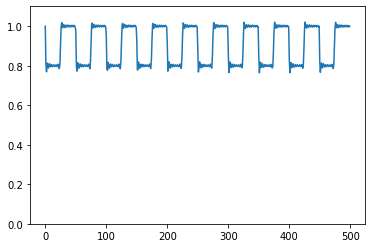

In [9]:
tpts = linspace(0,0.05,500)
plt.plot(1 - 0.2*squarewave(0.5,0.005,tpts,30))
plt.ylim((0,1.1))

(0.0, 1.1)

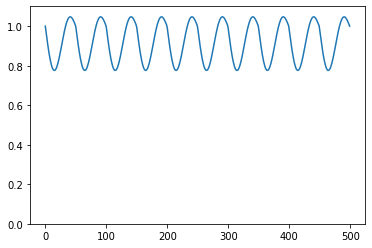

In [4]:
tpts = linspace(0,0.05,500)
plt.plot(1 - 0.2*squarewave(0.5,0.005,tpts,3))
plt.ylim((0,1.1))

(0.0, 1.1)

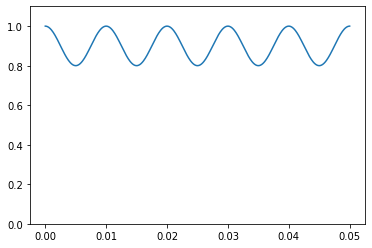

In [7]:
freq = 100
a = lambda t: 1 - 0.2*sin(pi*t*freq)**2
tpts = linspace(0,0.05,500)
plt.plot(tpts,a(tpts))
plt.ylim((0,1.1))